In [1]:
import scipy
import xarray as xr
import grib2io
import pandas as pd
import datetime
from glob import glob
import numpy as np
from corner import quantile
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib
matplotlib.rcParams.update({
 "savefig.facecolor": "w",
 "figure.facecolor" : 'w',
 "figure.figsize" : (8,6),
 "text.color": "k",
 "legend.fontsize" : 20,
 "font.size" : 30,
 "axes.edgecolor": "k",
 "axes.labelcolor": "k",
 "axes.linewidth": 3,
 "xtick.color": "k",
 "ytick.color": "k",
 "xtick.labelsize" : 25,
 "ytick.labelsize" : 25,
 "ytick.major.size" : 12,
 "xtick.major.size" : 12,
 "ytick.major.width" : 2,
 "xtick.major.width" : 2,
 "font.family": 'STIXGeneral',
 "mathtext.fontset" : "cm"})
from PIL import Image
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from mpl_toolkits.basemap import Basemap
from pyproj import Proj
from metpy.units import units
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## Data Assimilation and Coalescence

In the blend, there are ~17 models used to construct the value distributions for each variable (temp, precip, etc.). Some of these models are themselves made of an ensemble of models with different perturbation states (so in reality, 200+ realizations). In QM, each of these ensemble members would be mapped to the CDF constructed from the entire sample, but this can introduce issues originating from errors in the magnitude, timing, and location of weather events. Coalecence attempts to conform these ensemble members to the ensemble mean using the feature align technique in order to alleviate these errors while maintaining the distribution of events predicted by the individual ensemble members. 

In the most general terms, data assimilation techniques attempt to combine theoretical models with observations in the "best way possible." For our purposes, this relates to rectifying errors in both the forecast (magnitude, location and timing of event) and the necessarily sparse observations of the true system state.

D data assimilation usually takes a forecast (also known as the first gueon) and applies a correction to the forecast based on a set of observed data and estimated errors that are present in both the observations and the forecast itself. The difference between the forecast and the observations at that time is called the departurns it provides new information to the data assimilation process). A weighting factor is applied to the innovation to determine how much of a correction should be made to the forecast based on the new information from the observations. The best estimate of the state of the system based on the correction to the forecast determined by a weighting factor times the innovation is called the analysi

In particular, correcting for the errors associated with both position and amplitude is difficult; "the standard measures of forecast skill, such as root-meansquare (r.m.s.) error and anomaly correlation all measure forecast error as the difference between a forecast and ananalysis at the same point in space and time. They are incapable of identifying a phase error as such. For example, a forecast of an intense, fast-moving feature can have a low skill score because ofa small phase error that a human forecaster may consider minor. Hence, there is a need for an objective skill evaluation method that accounts for the presence of both phase and amplitude errors" (Nehrkorn+2003). 

Here, I'll attempt to walk through some examples outlined in Ravela+2006, Brewster+2002, and Ravela+2012 to demonstrate the general concept of data assimilation (using various techniques) and coalescence, as defined in Ravela+2012.
s.

## Correcting Position and Amplitude Errors with Field Alignment (Ravela+2006)

As an example, I'll walkthrough the two 1D examples of forecasts with amplitude and position errors. In the first example, the forecast ensemble has a position error but every ensemble member has the _same_ offset from the true position, in addition to amplitude errors. In the second example, the ensemble again has position and amplitude errors but each member has a unique position offset. 

The demo in Ravela+2006 first demonstrates that typical data assimilation techniques that consider only amplitude errors are unfit for these problems.

example 1:
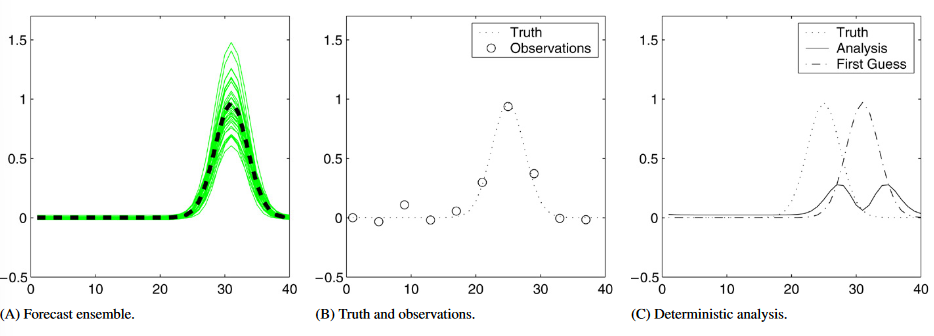


example 2:

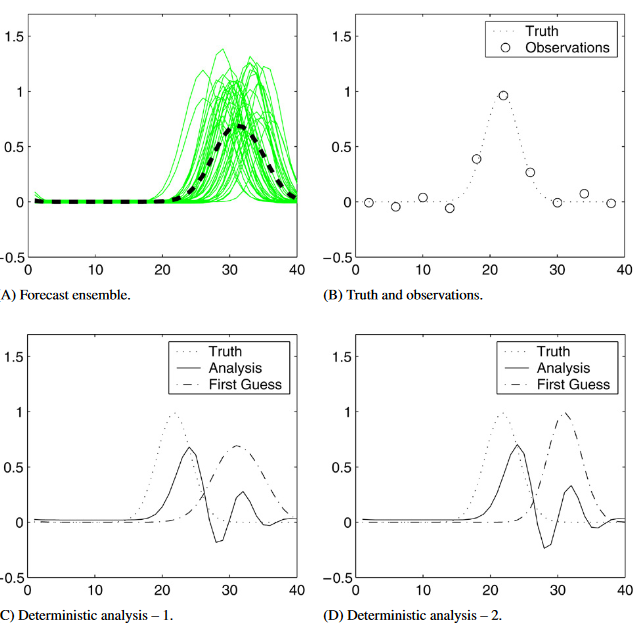


"The analysis from the procedure just discussed is shown. It is clear that the analysis (solid line) looks like neither the forecast ensemble nor the truth. It’s somewhere in between, being pulled by the observations in some places and the background at others. It has replaced a single front with a bimodal front of far weaker strength," (Ravela+2006).


"To address the position error problem, we reformulate the classical quadratic objective in a way that allows position adjustments in addition to amplitude adjustments. The key step in this new approach is to explicitly represent and minimize position errors. Therefore, we introduce auxiliary control variables (displacements) that are estimated along with amplitudes. The displacement variables are defined at each node of the grid representing the state and specify a deformation of the grid."